# Mortality Prediction and Interpretation
###  Alberto Mosconi and Richard Allen

December 11, 2020. The following Jupyter Notebook is intended for the Harvard class CS109a Final Project, see background information about the project as well as its scope and goals in the pdf report.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator

from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.inspection import permutation_importance
import shap

## Preliminaries

In [2]:
#First, we import our data as pandas dataframes.
X = pd.read_csv('data/NHANESI_X.csv')
y = pd.read_csv('data/NHANESI_Y.csv')

In [3]:
X.head(5)

Unnamed: 0   Age  Diastolic BP  Poverty index  Race  Red blood cells  \
0           0  35.0          92.0          126.0   2.0             77.7   
1           1  71.0          78.0          210.0   2.0             77.7   
2           2  74.0          86.0          999.0   2.0             77.7   
3           3  64.0          92.0          385.0   1.0             77.7   
4           4  32.0          70.0          183.0   2.0             77.7   

   Sedimentation rate  Serum Albumin  Serum Cholesterol  Serum Iron  \
0                12.0            5.0              165.0       135.0   
1                37.0            4.0              298.0        89.0   
2                31.0            3.8              222.0       115.0   
3                30.0            4.3              265.0        94.0   
4                18.0            5.0              203.0       192.0   

   Serum Magnesium  Serum Protein  Sex  Systolic BP   TIBC    TS  \
0             1.37            7.6  2.0        142.0  323.0  41.8   
1             1.38            6.4  2.0        156.0  331.0  26.9   
2             1.37            7.4  2.0        170.0  299.0  38.5   
3             1.97            7.3  2.0        172.0  349.0  26.9   
4             1.35            7.3  1.0        128.0  386.0  49.7   

   White blood cells        BMI  Pulse pressure  
0                5.8  31.109434            50.0  
1                5.3  32.362572            78.0  
2                8.1  25.388497            84.0  
3                6.7  26.446610            80.0  
4                8.1  20.354684            58.0

In [4]:
#We drop the 'Unnamed: 0' column from both X and y 
X = X.drop('Unnamed: 0', axis = 1)
y = y.drop('Unnamed: 0', axis = 1)

In [5]:
#We note that we have two categorical variables: Race and Sex. We change Sex to a binary variable with values 0 (Male)
#and 1 (Female and one-hot encode Race.
num_races = len(X['Race'].value_counts())
X['Sex'] = X['Sex'] - 1
for i in range(1,num_races + 1):
    X['Race' + str(i) + 'Bin'] = [1 if x == i else 0 for x in X['Race']]

In [6]:
#We confirm that the one-hot encoding was successful.
X[['Race'] + ['Race' + str(i) + 'Bin' for i in range(1, num_races + 1)]].head(5)

Race  Race1Bin  Race2Bin  Race3Bin
0   2.0         0         1         0
1   2.0         0         1         0
2   2.0         0         1         0
3   1.0         1         0         0
4   2.0         0         1         0

In [7]:
#We drop the unnecessary column and one of the one-hot encoded columns to avoid collinearity
#We also drop Pulse pressure, since it is perfectly multicollinear with the two BP readings (it equals their difference)
X = X.drop(['Race','Race3Bin','Pulse pressure'], axis = 1)

After much discussion on Ed and otherwise, it was determined that the output variable y is either equal to the time after the initial survey that the patient died (if $y > 0$) or the negative of the time which passed before contact was lost with the patient (if $y < 0$). This explains the preponderance of high negative values: these correspond to the last follow-up study in 1992. To verify that this is a reasonable interpretation of the y values, we plot the distributions of ages for patients with y values above and below zero:

In [8]:
print(f'The maximum and minimum values of the response variable are {round(max(y.values)[0],3)} and {round(min(y.values)[0],3)}.')

The maximum and minimum values of the response variable are 21.471 and -22.059.


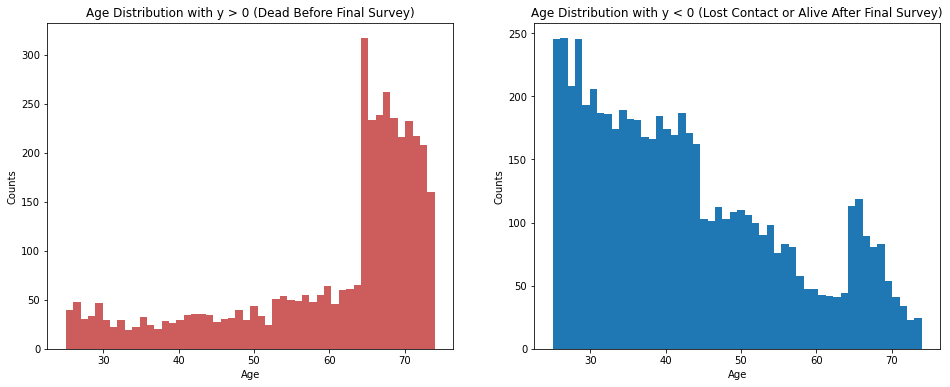

In [9]:
dead_ages = []
not_dead_ages = []
for i in range(y.shape[0]):
    if float(y.iloc[i]) >= 0:
        dead_ages.append(X['Age'].iloc[i])
    else:
        not_dead_ages.append(X['Age'].iloc[i])

fig, ax = plt.subplots(1,2, figsize = (16,6))

ax[0].hist(dead_ages, bins = 50, color = 'indianred')
ax[0].set(title = 'Age Distribution with y > 0 (Dead Before Final Survey)', xlabel = 'Age', ylabel = 'Counts')
ax[1].hist(not_dead_ages, bins = 50)
ax[1].set(title = 'Age Distribution with y < 0 (Lost Contact or Alive After Final Survey)', xlabel = 'Age', ylabel = 'Counts')

plt.show()

The fact that the age distribution of those with $y > 0$ is right-skewed indicates that the above interpretation is accurate.

We now need to construct our target variable. We will perform regression on time survived until contact was lost (due to death or otherwise). This choice of variable is explained further in our report. 

In [10]:
survival_until_lost = np.abs(y)

## Exploratory Data Analysis
#### Comparison to External Sources

In [11]:
#We split into train and test, adding a random state for the sake of reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, survival_until_lost, train_size = .8, random_state = 109)

#We reindex to avoid issuing during standardization
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [12]:
#As a very first pass, we take a look at the statistics provided by the .describe() method
X_train_desc = X_train.describe()
X_train_desc

Age  Diastolic BP  Poverty index  Red blood cells  \
count  7945.000000   7898.000000    7945.000000      7945.000000   
mean     49.451982     83.248037     288.990183        54.938641   
std      15.896284     13.332070     225.381971        14.641558   
min      25.000000     34.000000       2.000000        25.500000   
25%      35.000000     74.000000     130.000000        45.000000   
50%      48.000000     80.000000     233.000000        48.900000   
75%      66.000000     90.000000     373.000000        57.800000   
max      74.000000    180.000000     999.000000        88.800000   

       Sedimentation rate  Serum Albumin  Serum Cholesterol   Serum Iron  \
count         7283.000000    7945.000000        7945.000000  7945.000000   
mean            16.325278       4.365689         221.184342   101.244556   
std             11.511004       0.333099          49.187922    37.222684   
min              1.000000       2.700000          53.000000    17.000000   
25%              7.000000       4.200000         187.000000    75.000000   
50%             14.000000       4.400000         217.000000    96.000000   
75%             22.000000       4.600000         250.000000   122.000000   
max             65.000000       5.700000         793.000000   396.000000   

       Serum Magnesium  Serum Protein          Sex  Systolic BP         TIBC  \
count      7945.000000    7945.000000  7945.000000  7899.000000  7945.000000   
mean          1.680526       7.099874     0.605664   134.845677   362.220516   
std           0.144558       0.509299     0.488738    24.918837    58.572703   
min           0.860000       4.700000     0.000000    80.000000   112.000000   
25%           1.590000       6.800000     0.000000   118.000000   322.000000   
50%           1.680000       7.100000     1.000000   130.000000   355.000000   
75%           1.770000       7.400000     1.000000   150.000000   395.000000   
max           2.890000      11.500000     1.000000   270.000000   717.000000   

                TS  White blood cells          BMI     Race1Bin     Race2Bin  
count  7945.000000        7104.000000  7945.000000  7945.000000  7945.000000  
mean     28.628685           7.432418    25.675063     0.814349     0.174827  
std      11.303197           2.255235     5.192542     0.388850     0.379843  
min       3.200000           2.100000    12.585333     0.000000     0.000000  
25%      21.100000           6.000000    22.083849     1.000000     0.000000  
50%      27.300000           7.200000    24.915560     1.000000     0.000000  
75%      34.600000           8.600000    28.335305     1.000000     0.000000  
max     100.000000          56.000000    72.218113     1.000000     1.000000

In [13]:
#We compare the means of the features to ranges of normal values as reported by the American College of Physicians (ACP)
normal_df = pd.read_csv('data/normal_lab_csv')
normal_df['Average Value from Training Data'] = np.array(X_train_desc.drop(['Age', 'Poverty index', 'Sex', 'Race1Bin', 'Race2Bin'], axis = 1).loc['mean'])
normal_df

Feature  Lower Bound  Upper Bound     Units  \
0         Diastolic BP         60.0         80.0     mm Hg   
1      Red blood cells         42.0         59.0  10^5/muL   
2   Sedimentation rate          0.0         20.0     mm/hr   
3        Serum Albumin          3.5          5.5      g/dL   
4    Serum Cholesterol        150.0        199.0     mg/dL   
5           Serum Iron         60.0        160.0    mug/dL   
6      Serum Magnesium          1.5          2.4     mg/dL   
7        Serum Protein          6.0          7.8      g/dL   
8          Systolic BP         90.0        120.0     mm Hg   
9                 TIBC        250.0        460.0    mug/dL   
10                  TS         20.0         50.0         %   
11   White blood cells          4.0         10.0    10^9/L   
12                 BMI         18.5         24.9  Unitless   

    Average Value from Training Data  
0                          83.248037  
1                          54.938641  
2                          16.325278  
3                           4.365689  
4                         221.184342  
5                         101.244556  
6                           1.680526  
7                           7.099874  
8                         134.845677  
9                         362.220516  
10                         28.628685  
11                          7.432418  
12                         25.675063

All average values fall within the range considered normal by the ACP except for BMI, Diastolic BP, Systolic BP, and Serum Cholesterol. The BMI and BP readings, however, are only slightly elevated, and they are within reason when compared to the average values of these metric by the CDC (as discussed further in our report).

The cholesterol reading is another story; it is highly elevated with respect to today's averages. However, this can be explained by the fact that statins were not invented until after the 1975 NHANES I survey. This is discussed further in our report.

#### Distributions of Individual Features

We first take a look at bar charts of the binary predictors (sex and race).

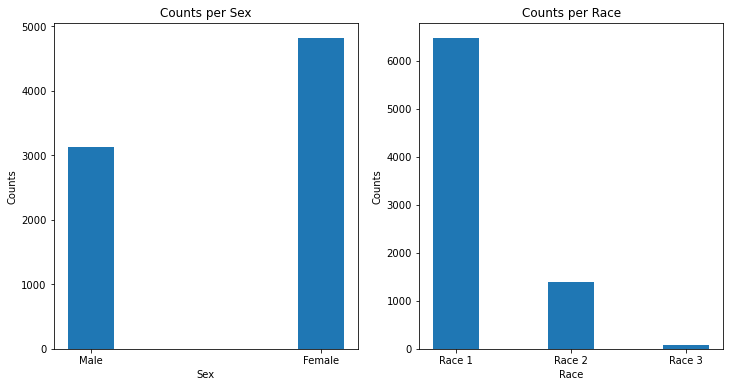

In [14]:
female_cts = X_train['Sex'].sum()
male_cts = X_train.shape[0] - female_cts
race1_cts = X_train['Race1Bin'].sum()
race2_cts = X_train['Race2Bin'].sum()
race3_cts = X_train.shape[0] - (race1_cts + race2_cts)

fig, axs = plt.subplots(1,2, figsize = (12,6))

axs.ravel()[0].bar([0, 1], [male_cts, female_cts], width = .2)
axs.ravel()[0].set_xticks([0,1])
axs.ravel()[0].set_xticklabels(['Male','Female'])
axs.ravel()[0].set(title = 'Counts per Sex', xlabel = 'Sex', ylabel = 'Counts')

axs.ravel()[1].bar([0, .5, 1], [race1_cts, race2_cts, race3_cts], width = .2)
axs.ravel()[1].set_xticks([0,.5,1])
axs.ravel()[1].set_xticklabels(['Race 1','Race 2', 'Race 3'])
axs.ravel()[1].set(title = 'Counts per Race', xlabel = 'Race', ylabel = 'Counts')

plt.show()

We notice that the data is pretty heavily female-skewed. This may be in part due to the intentional oversampling of  women of childbearing age for the NHANES I study. We also notice a sharp drop in representation for the three races.

We now plot the kernel density estimation of each of our variables.

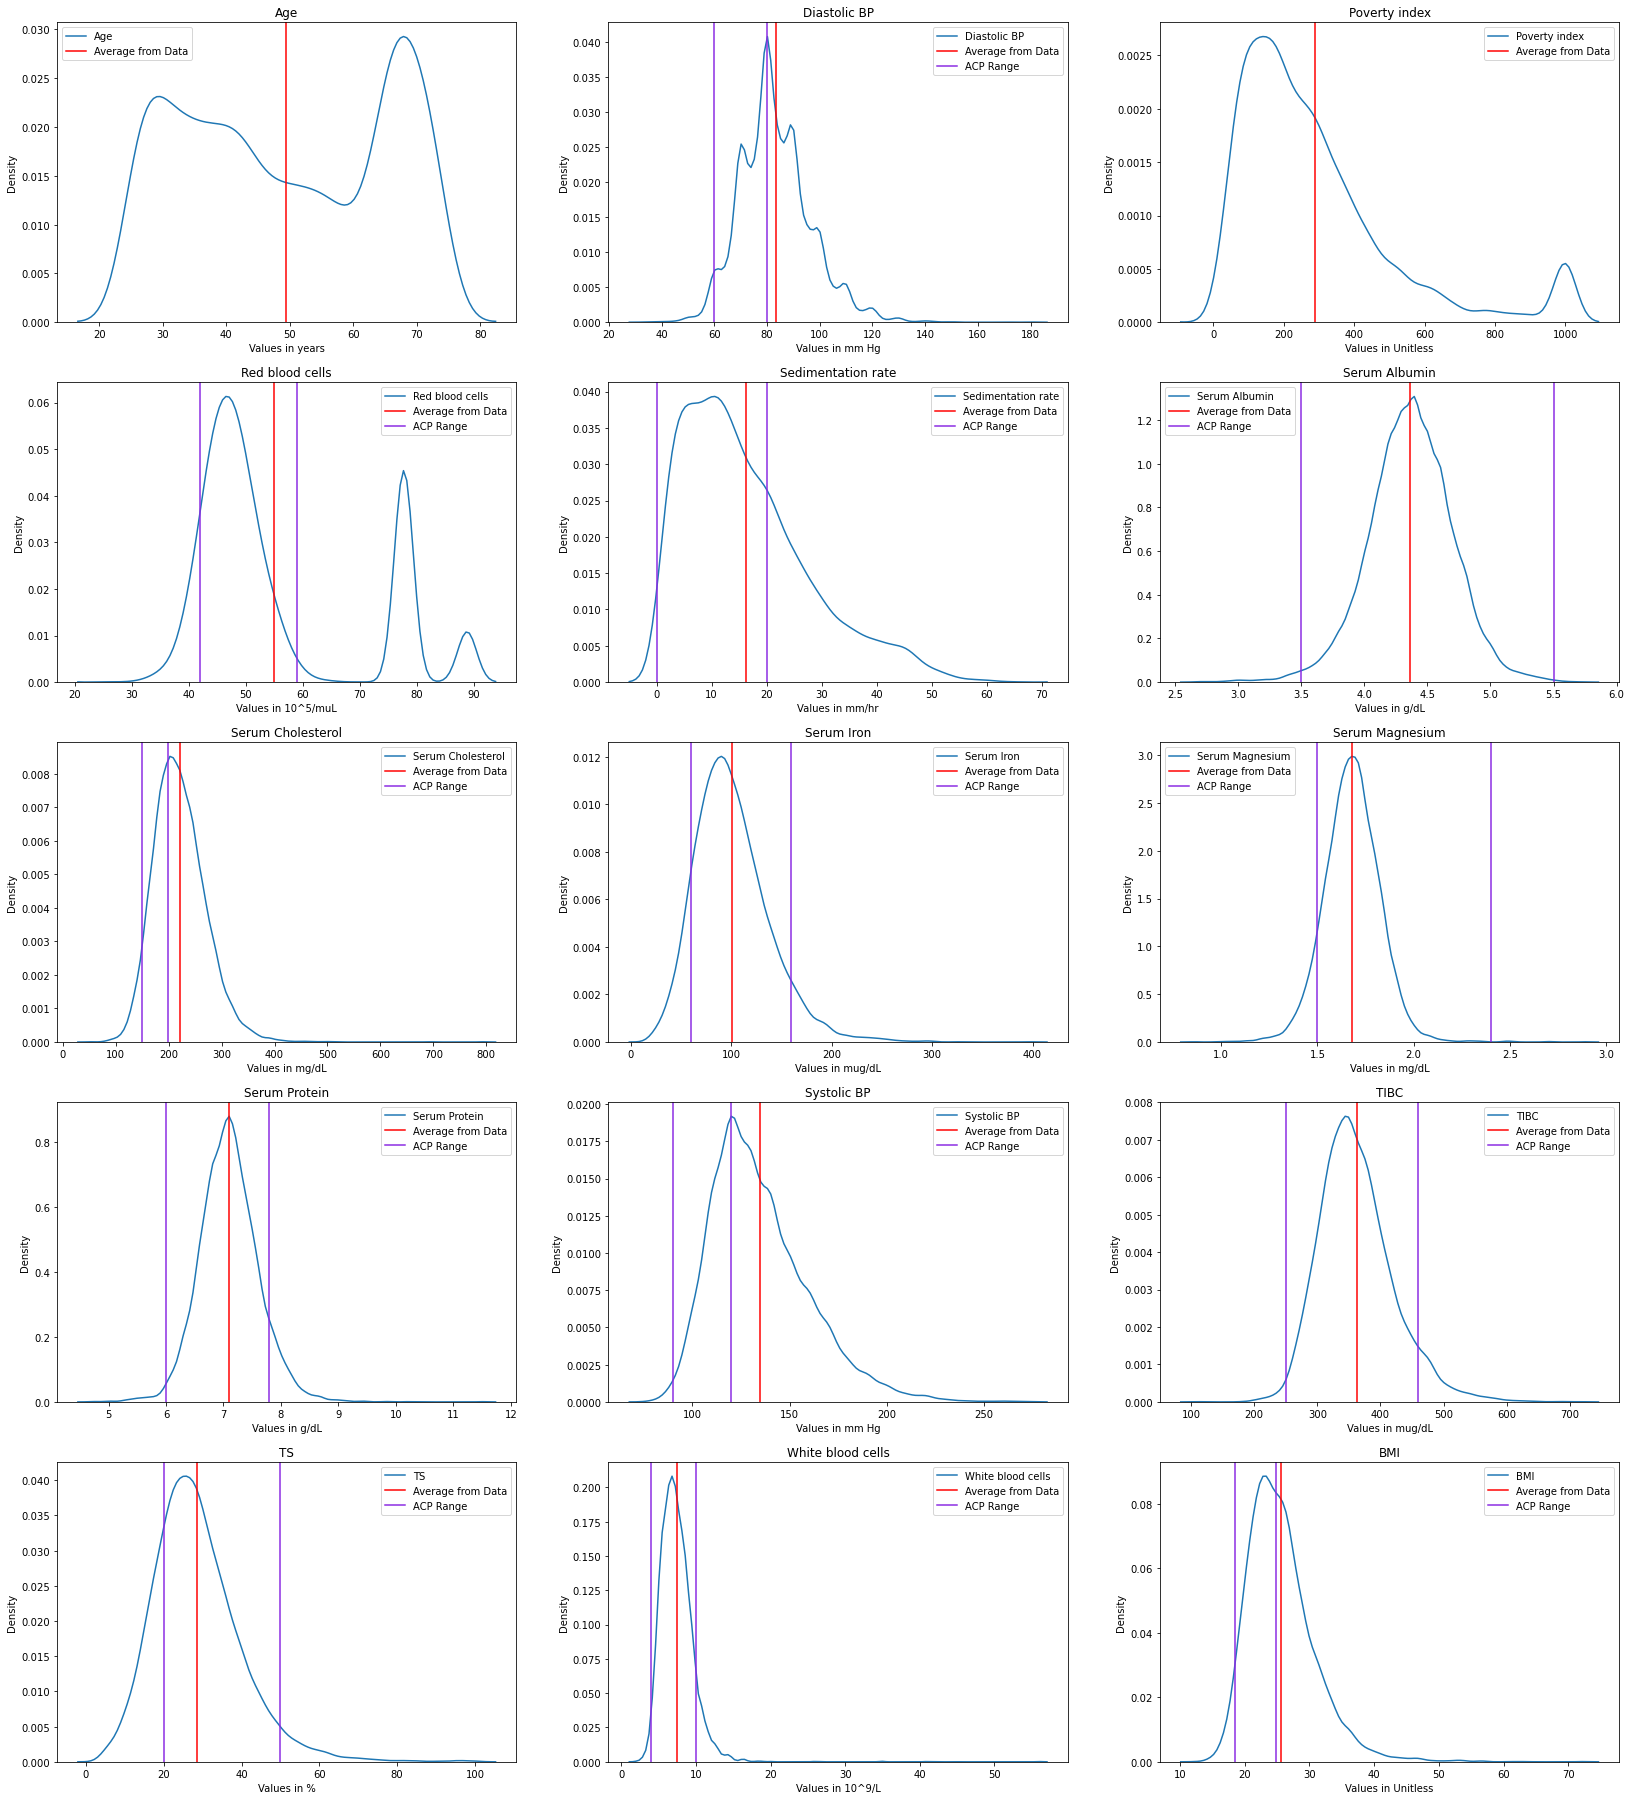

In [15]:
bin_preds = ['Sex', 'Race1Bin', 'Race2Bin']
non_bin_preds = [col for col in X_train.columns if col not in bin_preds]
units = {normal_df.loc[i, 'Feature'] : normal_df.loc[i, 'Units'] for i in range(normal_df.shape[0])}
units['Age'] = 'years'
units['Poverty index'] = 'Unitless'

#Now we plot
fig, axs = plt.subplots(5,3, figsize = (28,32))

for pred in non_bin_preds:
    ind = non_bin_preds.index(pred)
    sns.kdeplot(X_train[pred], ax = axs.ravel()[ind])
    axs.ravel()[ind].set(title = pred, xlabel = 'Values in '+units[pred], ylabel = 'Density')
    axs.ravel()[ind].axvline(X_train_desc.loc['mean', pred], label = 'Average from Data', color = 'r')
    if pred in list(normal_df['Feature']):
        axs.ravel()[ind].axvline(float(normal_df.loc[normal_df['Feature'] == pred, 'Lower Bound']), color = 'blueviolet', label = 'ACP Range')
        axs.ravel()[ind].axvline(float(normal_df.loc[normal_df['Feature'] == pred, 'Upper Bound']), color = 'blueviolet')
    axs.ravel()[ind].legend()

The KDE plots agree with our observations regading average. Most are normally distributed, but the predictors Age, Poverty Index, and Red Blood cells demonstrate some non-Gaussian behavior. The first two can be explained by the intentional oversampling of the elderly and impoverished, as explained in our report. The behavior of the last is more strange, as the plots below indicate.

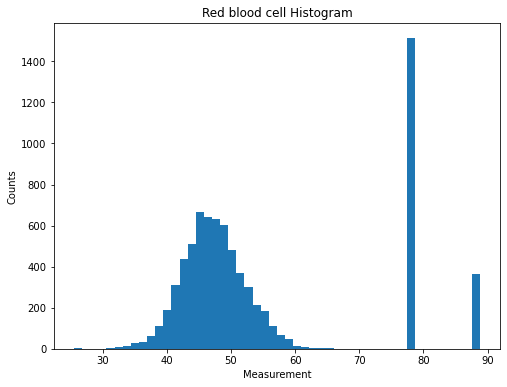

In [16]:
fig, ax = plt.subplots(figsize = (8,6))

ax.hist(X_train['Red blood cells'], bins =50)
ax.set(title = 'Red blood cell Histogram', xlabel = 'Measurement', ylabel = 'Counts')
plt.show()

Upon taking a closer look at the RBC counts with these histograms, we find an abnormally high number of counts at 77.7 and 88.8. We interpret this as a proxy for missing values and remove those observations.

In [17]:
X_train_rbc = X_train['Red blood cells'].replace([77.7,88.80000000000003], pd.NA)
X_train['Red blood cells'] = X_train_rbc
X_test_rbc = X_test['Red blood cells'].replace([77.7,88.80000000000003], pd.NA)
X_test['Red blood cells'] = X_test_rbc

#### Correlations between Predictors

After looking at the distributions of single predictors, we examine correlations between predictors. We will soon find, however, that our data is missing a large number of values, and we only want to compute correlations after imputation, so the actual code for this EDA will be relocated to the "Single Decision Tree" subsection of the "Modeling" section, where we have decided on an imputation method.

#### Marginal Associations with Outcome Variable

We will plot the association of each variable with the outcome, both as a scatter plot and through an averaging process described in our report and carried out by the code below.

In [18]:
def quantiles(x,y,inc):
    bounds = [x.quantile(q = i*inc, interpolation = 'lower') for i in range(int(1/inc))]
    boundspad = [bounds[0]] + bounds + [bounds[-1]]
    inds = [list(x[(x >= (boundspad[i] +  boundspad[i-1])/2) & (x <= (boundspad[i] + boundspad[i+1])/2)].index) for i in range(1, len(boundspad) - 1)]
    y_avgs = [y.loc[inds[i]].mean() for i in range(len(inds))]
    return bounds, y_avgs

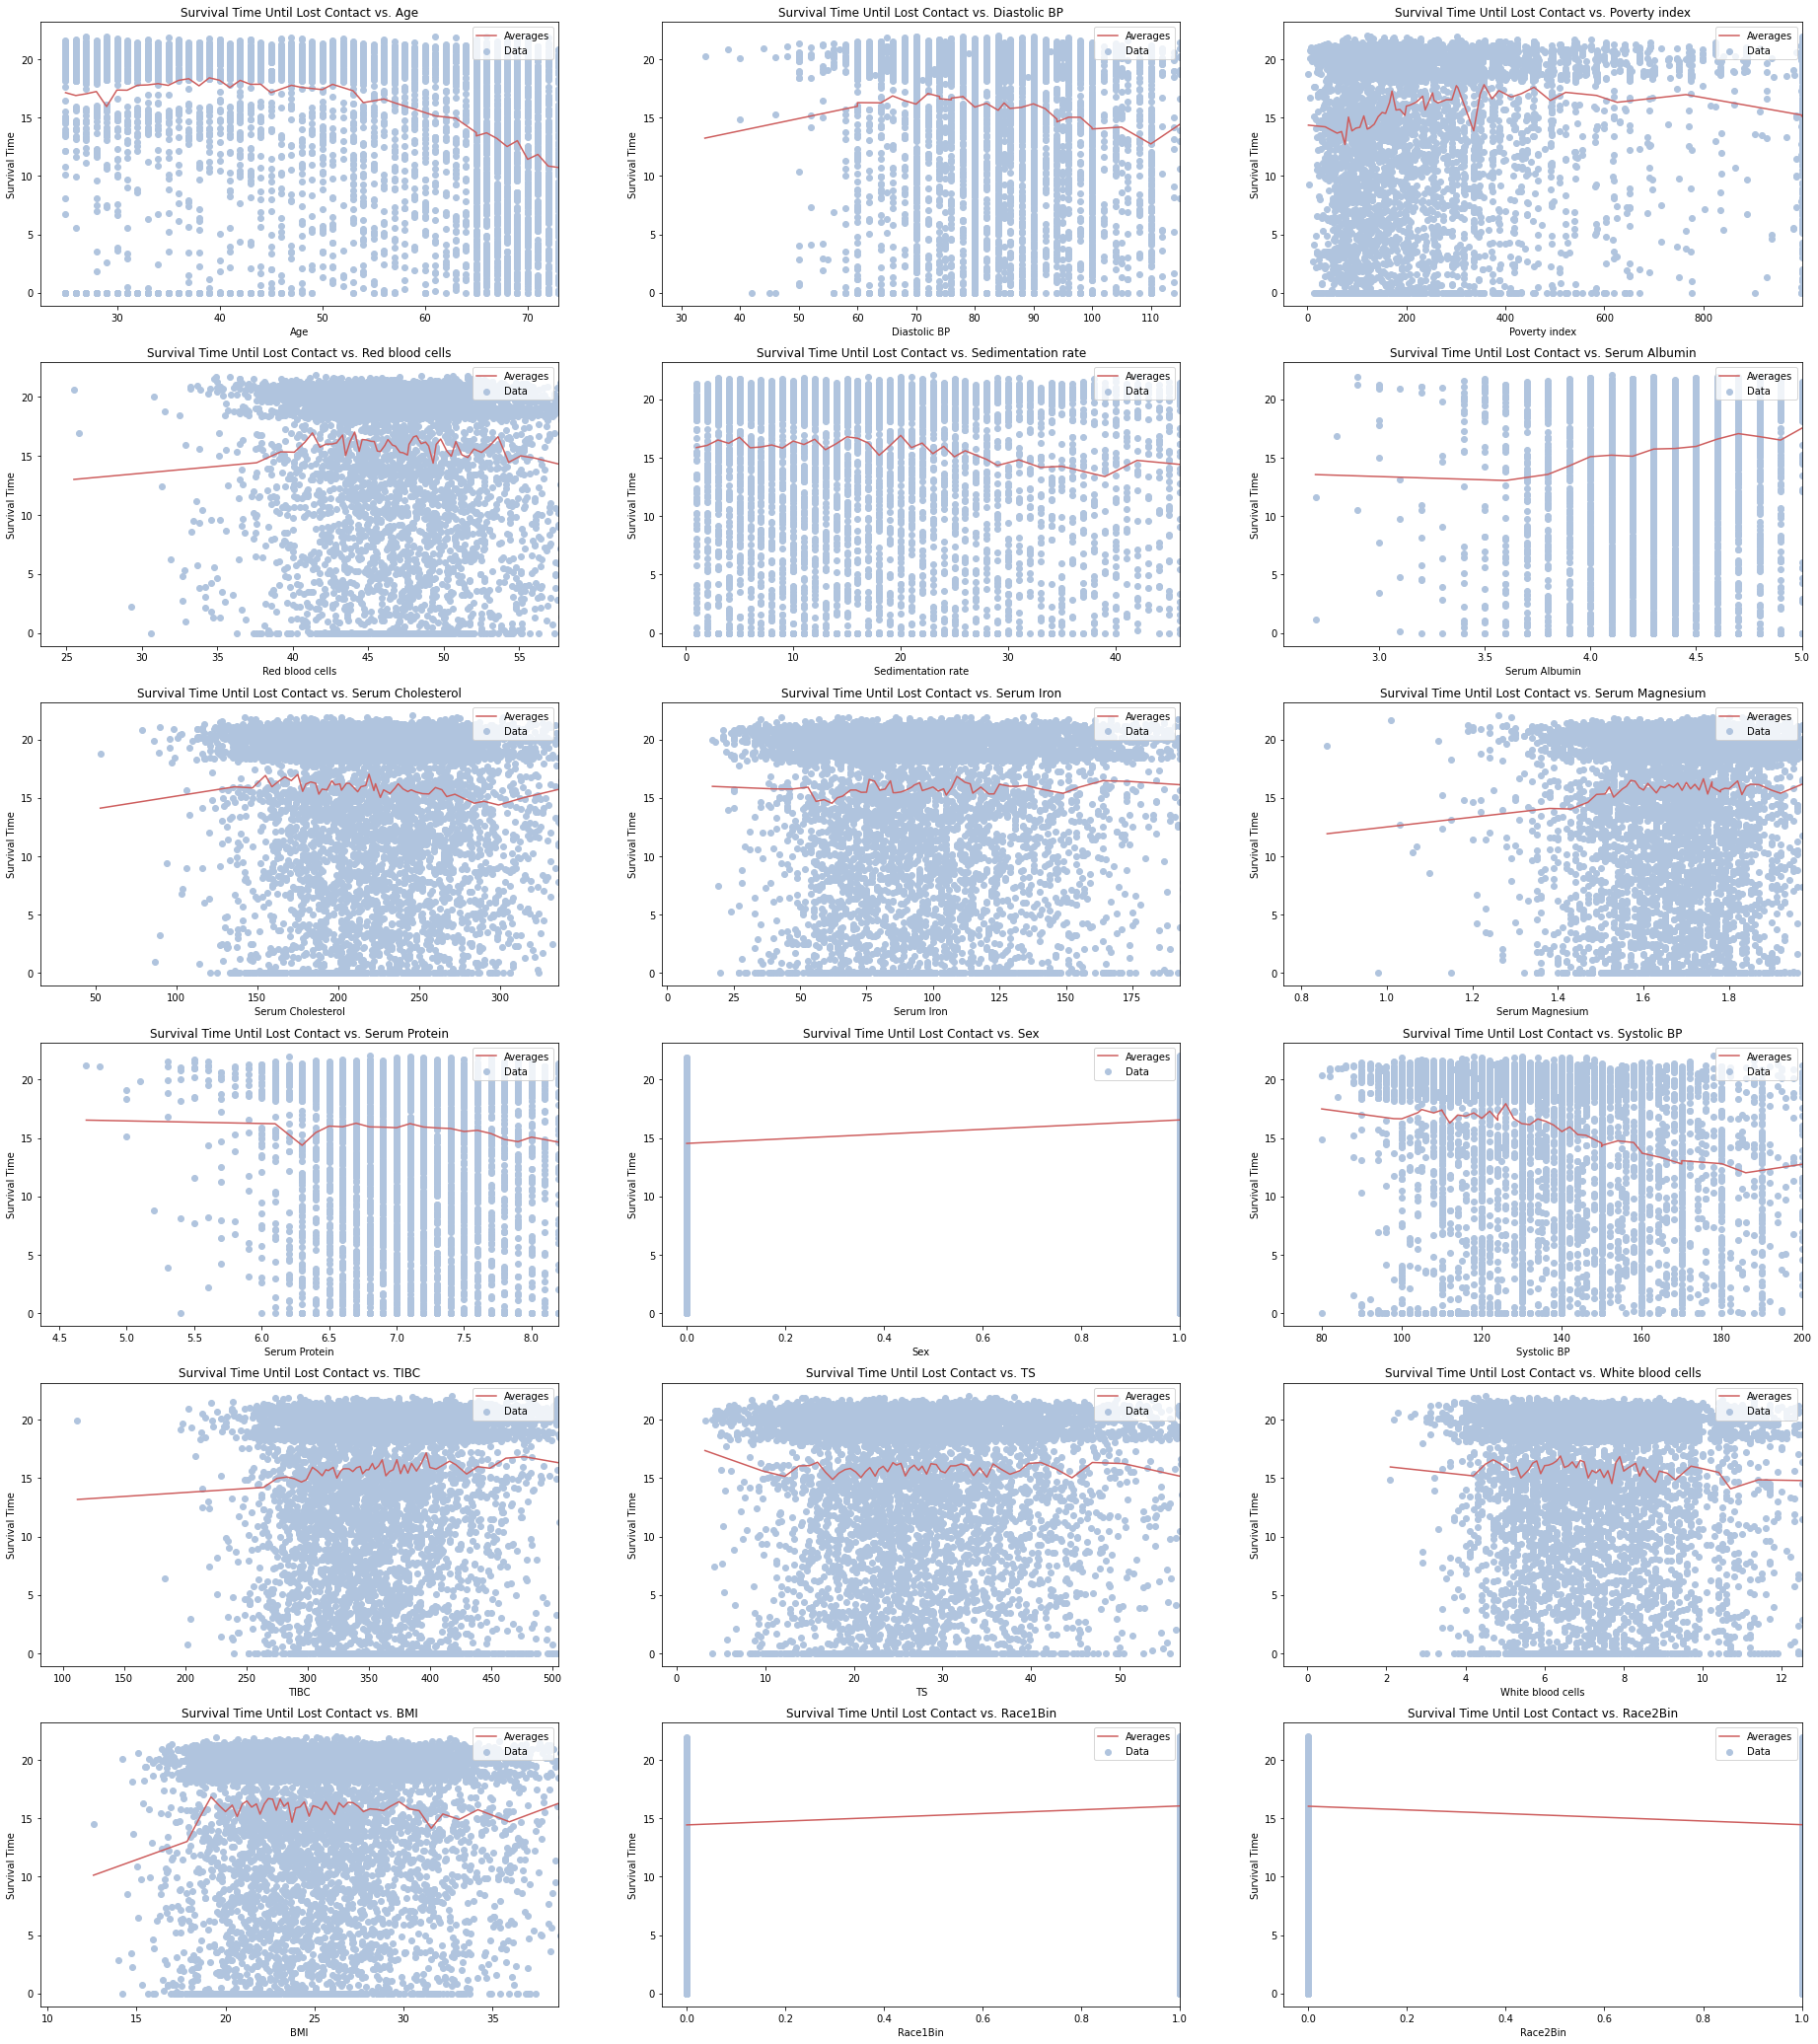

In [19]:
fig, axs = plt.subplots(6,3, figsize = (32,37))
for i in range(len(X_train.columns)):
    axs.ravel()[i].scatter(X_train[X_train.columns[i]], y_train, label = 'Data', color = 'lightsteelblue')
    quants = quantiles(X_train[X_train.columns[i]], y_train, .02)
    axs.ravel()[i].plot(quants[0], quants[1], label = 'Averages', color = 'indianred')
    axs.ravel()[i].set(title = 'Survival Time Until Lost Contact vs. ' + X_train.columns[i], xlabel = X_train.columns[i], ylabel = 'Survival Time')
    axs.ravel()[i].legend(loc = 'upper right')
    axs.ravel()[i].set_xlim(right = np.array(quants[0]).reshape(1,-1)[0][-1])

## Data Cleaning:
#### Data Types, Missing Values

In [20]:
X_train.dtypes

Age                   float64
Diastolic BP          float64
Poverty index         float64
Red blood cells       float64
Sedimentation rate    float64
Serum Albumin         float64
Serum Cholesterol     float64
Serum Iron            float64
Serum Magnesium       float64
Serum Protein         float64
Sex                   float64
Systolic BP           float64
TIBC                  float64
TS                    float64
White blood cells     float64
BMI                   float64
Race1Bin                int64
Race2Bin                int64
dtype: object

All predictors are of the correct data type, so there is no cause for concern here. We now check for missing values.

In [21]:
for col in X_train.columns:
    if X_train[col].isnull().sum() != 0:
        print(f'There are {X_train[col].isnull().sum()} missing values for the predictor {col}.')

There are 47 missing values for the predictor Diastolic BP.
There are 1876 missing values for the predictor Red blood cells.
There are 662 missing values for the predictor Sedimentation rate.
There are 46 missing values for the predictor Systolic BP.
There are 841 missing values for the predictor White blood cells.


In [22]:
y_train.isnull().sum()

y    0
dtype: int64

In [23]:
print(f'Of the {X_train.shape[0]} total training observations, {X_train.shape[0] - X_train.dropna().shape[0]} are missing values.')

Of the 7945 total training observations, 2154 are missing values.


Fortunately, there are no missing values in the predictions, but there are indeed several missing values in our predictors. We have seen several reasonable methods for imputing missing values so far in the class, and we will try a few of them out below.

#### Standardization

One of our imputation methods relies on KNN, so we must standardize our data (this will also be useful for the models themselves).

In [24]:
#We should not standardize categorical predictors, so we remove these from the data to be standardized and reappend
#them afterwards.
cat_preds = ['Sex'] + ['Race' + str(i) + 'Bin' for i in range(1, num_races)]
X_train_non_cat = X_train.drop(cat_preds, axis = 1)
X_test_non_cat = X_test.drop(cat_preds, axis = 1)

sc = StandardScaler()
sc.fit(X_train_non_cat)
X_train_sc = pd.DataFrame(data = sc.transform(X_train_non_cat), columns = X_train_non_cat.columns)
X_test_sc = pd.DataFrame(data = sc.transform(X_test_non_cat), columns = X_test_non_cat.columns)

X_train_sc = pd.concat([X_train_sc, X_train[cat_preds]], axis = 1)
X_test_sc = pd.concat([X_test_sc, X_test[cat_preds]], axis = 1)

#### Imputation

Now that our data is properly rescaled, we will try a number of methods of imputation.

In [25]:
Xs = []
ys = []

#1. Just dropping any rows with missing values
Xs.append((X_train_sc.dropna(), X_test_sc.dropna(),'Drop'))
ys.append((y_train.loc[X_train_sc.dropna().index], y_test.loc[X_test_sc.dropna().index]))

#2. Imputation with mean values
mean_imputer = SimpleImputer(strategy = 'mean')
mean_imputer.fit(X_train_sc)
Xs.append((mean_imputer.transform(X_train_sc), mean_imputer.transform(X_test_sc), 'Mean'))
ys.append((y_train, y_test))

#3. KNN with multiple values of K
impute_ks = [1,3,5,10,15]
for k in impute_ks:
    knn_imputer = KNNImputer(n_neighbors = k)
    knn_imputer.fit(X_train_sc)
    Xs.append((knn_imputer.transform(X_train_sc), knn_imputer.transform(X_test_sc), 'k = ' + str(k)))
    ys.append((y_train, y_test))
    
#4. Experimental MICE-based Iterative Imputer
it_imputer = IterativeImputer()
it_imputer.fit(X_train_sc)
Xs.append((it_imputer.transform(X_train_sc),  it_imputer.transform(X_test_sc), 'Iterative'))
ys.append((y_train, y_test))

# Modeling
#### Single Decision Tree

In the interest of not having to train our more complex models on each of the imputed datasets, we will first train a single Decision Tree Regressor on each of the imputed datasets, cross-validating on depths, and select the data set and depth with the best mean squared error.

In [26]:
depths = list(range(1, 25))
cv = 5
dt_cvscores = pd.DataFrame(columns = ['Imputation Method', 'Training MSE', 'Best CV MSE', 'Depth'], index = range(len(Xs)))

for i in range(len(Xs)):
    train_scores = []
    cvmeans = []
    for depth in depths:
        dt = DecisionTreeRegressor(max_depth = depth)
        dt.fit(Xs[i][0], ys[i][0])
        train_scores.append(mean_squared_error(ys[i][0], dt.predict(Xs[i][0])))
        #Cross validate on depths for each imputed data set
        cv_scores = -cross_val_score(dt, Xs[i][0], ys[i][0], cv = cv, scoring = 'neg_mean_squared_error')
        cvmeans.append(np.mean(cv_scores))
    cvbest = min(cvmeans)
    dt_cvscores.loc[i] = [Xs[i][2], train_scores[cvmeans.index(cvbest)], cvbest, cvmeans.index(cvbest) + 1]

In [27]:
dt_cvscores

Imputation Method Training MSE Best CV MSE Depth
0              Drop      31.7251     32.4433     3
1              Mean      32.7771     33.3498     3
2             k = 1      32.7798     33.3653     3
3             k = 3      32.7728     33.3204     3
4             k = 5      32.7712     33.3241     3
5            k = 10      32.7771     33.3433     3
6            k = 15      32.7771     33.3644     3
7         Iterative      32.7701     33.3665     3

We see that the best MSE comes from the kNN imputed data with $k = 3$, so we will use this data for the remainder of our models.

In [28]:
X_train = pd.DataFrame(data = Xs[3][0], columns = X_train_sc.columns)
X_test = pd.DataFrame(data = Xs[3][1], columns = X_train_sc.columns)
y_train = ys[3][0]
y_test = ys[3][1]

For a better understanding of the variation of MSE with depth, we will plot the training MSE, mean CV MSE, and plus or minus 2 standard deviations away from this mean for a range of depths.

In [29]:
depths = list(range(1, 25))
max_depth = depths[-1]
cv = 5

def calc_meanstd(X_train, y_train, depths):
    # your code here
    train_scores, cvmeans, cvstds = [],[],[]
    #We create a decision tree for each max depth
    for depth in depths:
        dt = DecisionTreeRegressor(max_depth = depth)
        dt.fit(X_train, y_train)
        train_scores.append(mean_squared_error(y_train, dt.predict(X_train)))
        
        #We cross validate for each depth
        cv_scores = -cross_val_score(dt, X_train, y_train, cv = cv, scoring = 'neg_mean_squared_error')
        cvmeans.append(np.mean(cv_scores))
        cvstds.append(2*np.std(cv_scores))
        
    # end of your code here
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_scores= calc_meanstd(X_train, y_train, depths)

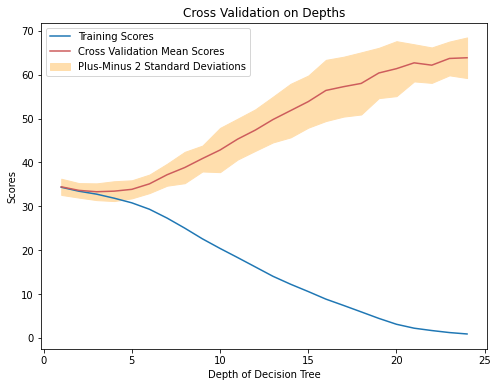

In [30]:
#We define lists contained \mu+2\sigma and \mu-2\sigma
lower_stds = [(cvmeans[i] - cvstds[i]) for i in range(max_depth)]
upper_stds = [(cvmeans[i] + cvstds[i]) for i in range(max_depth)]
figure, ax = plt.subplots(figsize = (8,6))

ax.plot(depths, train_scores, label = 'Training Scores')
ax.plot(depths, cvmeans, label = 'Cross Validation Mean Scores', c = 'indianred')
ax.fill_between(depths, lower_stds, upper_stds, color = 'navajowhite', label = "Plus-Minus 2 Standard Deviations")
ax.set(xlabel = 'Depth of Decision Tree', ylabel = 'Scores')
ax.legend(loc = 'best')
    
ax.set_title('Cross Validation on Depths')


plt.show()

Finally, we record the MSE on training and test for the best decision tree.

In [31]:
dt_best_depth = depths[cvmeans.index(min(cvmeans))]
dt_best_model = DecisionTreeRegressor(max_depth = dt_best_depth)
dt_best_model.fit(X_train, y_train)
dt_best_tuple = [dt_best_depth, mean_squared_error(y_train, dt_best_model.predict(X_train)), mean_squared_error(y_test, dt_best_model.predict(X_test))]


print(f'The best decision tree model had \nDepth: {dt_best_tuple[0]}\nTraining MSE: {round(dt_best_tuple[1],3)}\nTest MSE: {round(dt_best_tuple[2],3)}')

The best decision tree model had 
Depth: 3
Training MSE: 32.773
Test MSE: 31.532


We can now fulfill our promise of computating Pearson correlations between predictors.

In [32]:
abs_corr = X_train.corr().abs()
unstacked = abs_corr.unstack()
top_corr = unstacked.sort_values(kind="quicksort", ascending = False)
#Eliminate all perfect correlations
top_corr_filtered = top_corr[X_train.shape[1]:]
#Each is reported twice since Corr(A,B) = Corr(B,A), so we select only even entries
top_ten_corr = top_corr_filtered.iloc[[2*i for i in range(10)]]
top_ten_corr

Race1Bin         Race2Bin              0.964024
TS               Serum Iron            0.907356
Diastolic BP     Systolic BP           0.706620
Systolic BP      Age                   0.508985
Red blood cells  Sex                   0.452297
Serum Protein    Serum Albumin         0.450617
Red blood cells  Sedimentation rate    0.374379
TS               TIBC                  0.370877
Diastolic BP     BMI                   0.354489
Age              Serum Cholesterol     0.350808
dtype: float64

This is a good sanity check, but none of these correlations are especially surprising.

#### Bagging

We move to the next tier of tree-based models: bagged models. We will explore possible base classifier depths and number of bootstraps by evaluating on our test data and minimizing MSE.

In [33]:
#We will visualize our data using a colormap
def plot_cmap(ax, x1, x2, y, model, x1label, x2label):
    scatter_p = ax.scatter(x1, x2, c = y, cmap = 'plasma')
    cbar = plt.colorbar(scatter_p)
    cbar.ax.set_ylabel('Test MSE')
    ax.set_title('Test MSEs for ' + model)
    ax.set(xlabel = x1label, ylabel = x2label)

In [34]:
#We define a function that allows us to explore the possible hyperparameters for our models
def hyper_explore(model, hyp_lists, X_train, y_train, X_test, y_test, grad_depth = 5):
    mse_tuples = []
    if model == 'BaggingRegressor':
        depths, boots = hyp_lists[0], hyp_lists[1]
        for depth in depths:
            for boot in boots:
                base_est = DecisionTreeRegressor(max_depth = depth)
                bag_model = BaggingRegressor(base_est, n_estimators = boot, random_state = 111)
                bag_model.fit(X_train, np.array(y_train).reshape(1,-1)[0])
                train_mse = mean_squared_error(y_train, bag_model.predict(X_train))
                test_mse = mean_squared_error(y_test, bag_model.predict(X_test))
                mse_tuples.append((depth, boot, train_mse, test_mse))
                if (depths.index(depth)*len(boots) + boots.index(boot) + 1)%5 == 0:
                    print(f'{(depths.index(depth)*len(boots) + boots.index(boot) + 1)} done.')
    elif model == 'RandomForestRegressor':
        depths, boots = hyp_lists[0], hyp_lists[1]
        for depth in depths:
            for boot in boots:
                rf_model = RandomForestRegressor(max_depth = depth, max_features = int(len(X_train.columns)/3), n_estimators = boot, random_state = 118)
                rf_model.fit(X_train, np.array(y_train).reshape(1,-1)[0])
                train_mse = mean_squared_error(y_train, rf_model.predict(X_train))
                test_mse = mean_squared_error(y_test, rf_model.predict(X_test))
                mse_tuples.append((depth, boot, train_mse, test_mse))
                if (depths.index(depth)*len(boots) + boots.index(boot) + 1)%5 == 0:
                    print(f'{(depths.index(depth)*len(boots) + boots.index(boot) + 1)} done.')
    elif model == 'GradientBoostingRegressor':
        learns, stages = hyp_lists[0], hyp_lists[1]
        for learn in learns:
            for stage in stages:
                boost_model = GradientBoostingRegressor(max_depth = grad_depth, learning_rate = learn, n_estimators = stage, random_state = 112)
                boost_model.fit(X_train, np.array(y_train).reshape(1,-1)[0])
                train_mse = mean_squared_error(y_train, boost_model.predict(X_train))
                test_mse = mean_squared_error(y_test, boost_model.predict(X_test))
                mse_tuples.append((learn, stage, train_mse, test_mse))
                if (learns.index(learn)*len(stages) + stages.index(stage) + 1)%5 == 0:
                    print(f'{(learns.index(learn)*len(stages) + stages.index(stage) + 1)} done.')
                    
    best_tuple = mse_tuples[[tup[-1] for tup in mse_tuples].index(min([tup[-1] for tup in mse_tuples]))]
    return mse_tuples, best_tuple

In [35]:
bag_test_mse_tuples, bag_best_tuple = hyper_explore('BaggingRegressor', [[5,6,7,8], [55,60,65,70,75,80,85]], X_train, y_train, X_test, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.


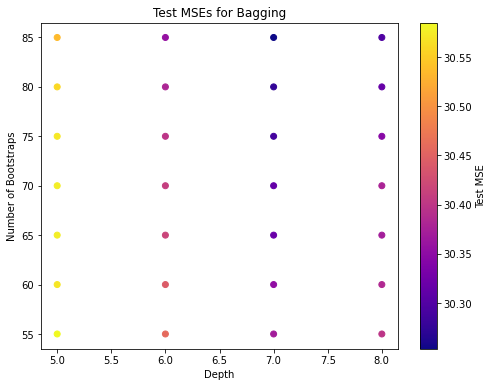

In [36]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in bag_test_mse_tuples], [tup[1] for tup in bag_test_mse_tuples], [tup[3] for tup in bag_test_mse_tuples], 'Bagging', 'Depth', 'Number of Bootstraps')

In [37]:
print(f'The best bagged model had \nDepth: {bag_best_tuple[0]}\nNumber of Bootstraps: {bag_best_tuple[1]}\nTraining MSE: {round(bag_best_tuple[2],3)}\nTest MSE: {round(bag_best_tuple[3],3)}')

The best bagged model had 
Depth: 7
Number of Bootstraps: 85
Training MSE: 25.832
Test MSE: 30.254


#### Random Forest

Next, we train a random forest model to our data, using the convention for regression of taking a third of the predictors at each node. We will again explore possible depths and number of bootstraps.

In [38]:
rf_test_mse_tuples, rf_best_tuple = hyper_explore('RandomForestRegressor', [[6,7,8,9,10], [40,45,50,55,60,65,70]], X_train, y_train, X_test, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.
30 done.
35 done.


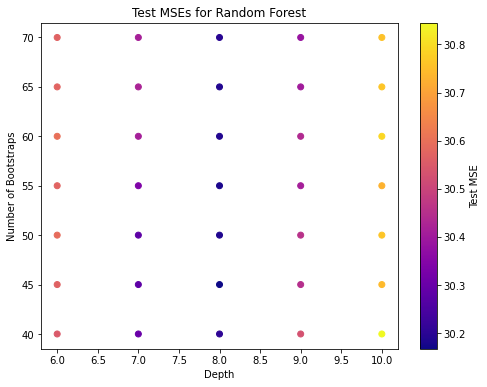

In [39]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in rf_test_mse_tuples], [tup[1] for tup in rf_test_mse_tuples], [tup[3] for tup in rf_test_mse_tuples], 'Random Forest', 'Depth', 'Number of Bootstraps')

In [40]:
print(f'The best random forest model had \nDepth: {rf_best_tuple[0]}\nNumber of Bootstraps: {rf_best_tuple[1]}\nTraining MSE: {round(rf_best_tuple[2],3)}\nTest MSE: {round(rf_best_tuple[3],3)}')

The best random forest model had 
Depth: 8
Number of Bootstraps: 45
Training MSE: 24.546
Test MSE: 30.167


#### Boosting

Finally, we will explore gradient boosted regression models. In separate cross-validation we found the best tree depth to be around 5, so we will stick to that value. We will explore possible learning rates and number of boosting stages.

In [41]:
boost_best_depth = 5

In [42]:
boost_test_mse_tuples, boost_best_tuple = hyper_explore('GradientBoostingRegressor', [[.02,.023,.025,.027,.03,.035,.04,.045,.05], [130,135,140,145,150,155,160,165,170]], X_train, y_train, X_test, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.
30 done.
35 done.
40 done.
45 done.
50 done.
55 done.
60 done.
65 done.
70 done.
75 done.
80 done.


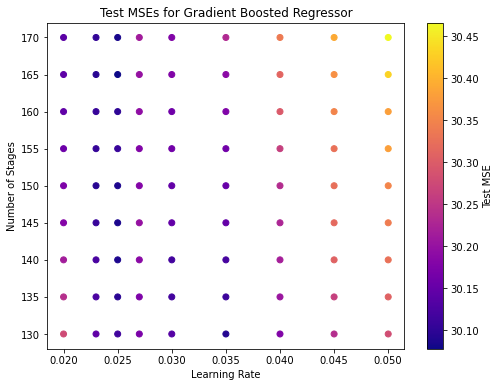

In [43]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in boost_test_mse_tuples], [tup[1] for tup in boost_test_mse_tuples], [tup[3] for tup in boost_test_mse_tuples], 'Gradient Boosted Regressor', 'Learning Rate', 'Number of Stages')

In [44]:
print(f'The best random gradient boosted model had \nLearning Rate: {boost_best_tuple[0]}\nNumber of Stages: {boost_best_tuple[1]}\nTraining MSE: {round(boost_best_tuple[2],3)}\nTest MSE: {round(boost_best_tuple[3],3)}')

The best random gradient boosted model had 
Learning Rate: 0.025
Number of Stages: 165
Training MSE: 25.028
Test MSE: 30.078


We compile the results of our best models into a single dataframe for ease of comparison.

In [45]:
best_model_results = pd.DataFrame(columns = ['Model', 'Depth', 'Number of Bootstraps/ Stages', 'Learning Rate', 'Training MSE', 'Test MSE'], index = range(4))
best_model_results.loc[0] = ['Decision Tree', dt_best_tuple[0], 'N/A', 'N/A', dt_best_tuple[1], dt_best_tuple[2]]
best_model_results.loc[1] = ['Bagged Model', bag_best_tuple[0], bag_best_tuple[1], 'N/A', bag_best_tuple[2], bag_best_tuple[3]]
best_model_results.loc[2] = ['Random Forest', rf_best_tuple[0], rf_best_tuple[1], 'N/A', rf_best_tuple[2], rf_best_tuple[3]]
best_model_results.loc[3] = ['Gradient Boosted', boost_best_depth, boost_best_tuple[1], boost_best_tuple[0], boost_best_tuple[2], boost_best_tuple[3]]

best_model_results

Model Depth Number of Bootstraps/ Stages Learning Rate  \
0     Decision Tree     3                          N/A           N/A   
1      Bagged Model     7                           85           N/A   
2     Random Forest     8                           45           N/A   
3  Gradient Boosted     5                          165         0.025   

  Training MSE Test MSE  
0      32.7728  31.5324  
1      25.8315  30.2536  
2      24.5458  30.1675  
3      25.0276  30.0781

We will need a copy of our best model for Feature Importance analysis below, so we train that now.

In [46]:
best_model_overall = GradientBoostingRegressor(max_depth = boost_best_depth, learning_rate = boost_best_tuple[0], n_estimators = boost_best_tuple[1], random_state = 109)
best_model_overall.fit(X_train, np.array(y_train).reshape(1,-1)[0])

GradientBoostingRegressor(learning_rate=0.025, max_depth=5, n_estimators=165,
                          random_state=109)

# Feature Selection

#### Feature Selection with F-Test

Our ultimate goal is to build a model with the optimal performance using the fewest number of predictors. Therefore, we should determine which features are the most "important" to the performance of the model. We will do so using a number of the techniques covered in the class.

For our first look at feature importance, we using a Regression F-test.

In [47]:
skb = SelectKBest(score_func = f_regression, k = 10)
skb.fit(X_train, np.array(y_train).reshape(1,-1)[0])

skb_inds = list(np.argsort(skb.scores_))
skb_inds.reverse()
skb_scores = skb.scores_[skb_inds][:10]
skb_scores = [score/max(skb_scores) for score in skb_scores]
skb_preds = X_train.columns[skb_inds][:10]

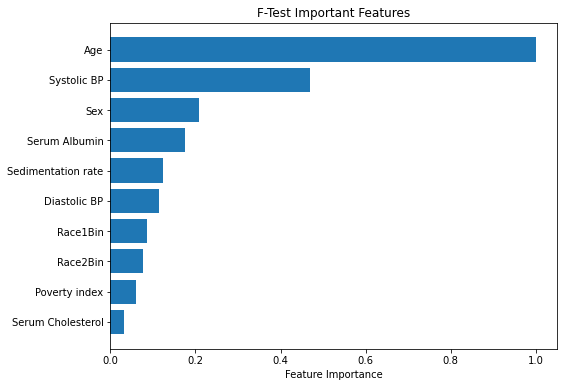

In [48]:
fig, ax = plt.subplots(figsize = (8,6))

ax.barh(list(range(10)), skb_scores, align = 'center')
ax.set_yticks(list(range(10)))
ax.set_yticklabels(skb_preds)
ax.invert_yaxis()
ax.set(xlabel = 'Feature Importance')
ax.set_title('F-Test Important Features')

plt.show()

#### Feature Selection with MDI

We next look at mean decrease impurity for our overall best model.

In [49]:
mdi_inds = list(np.argsort(best_model_overall.feature_importances_))
mdi_inds.reverse()
mdi_scores = best_model_overall.feature_importances_[mdi_inds][:10]
mdi_scores = [score/max(mdi_scores) for score in mdi_scores]
mdi_preds = X_train.columns[mdi_inds][:10]

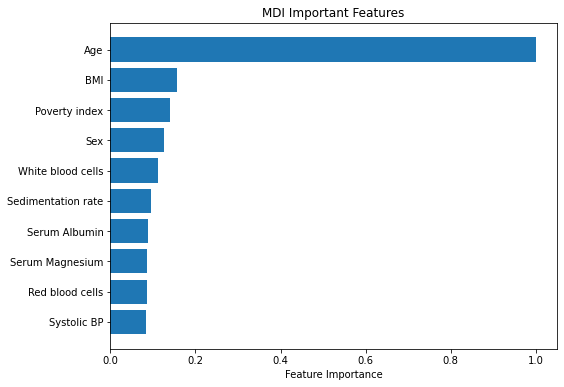

In [50]:
fig, ax = plt.subplots(figsize = (8,6))

ax.barh(list(range(10)), mdi_scores, align = 'center')
ax.set_yticks(list(range(10)))
ax.set_yticklabels(mdi_preds)
ax.invert_yaxis()
ax.set(xlabel = 'Feature Importance')
ax.set_title('MDI Important Features')

plt.show()

#### Feature Selection with Permutation Importance

We consider permutation importance (the trade-offs between MDI and PI are discussed further in the report).

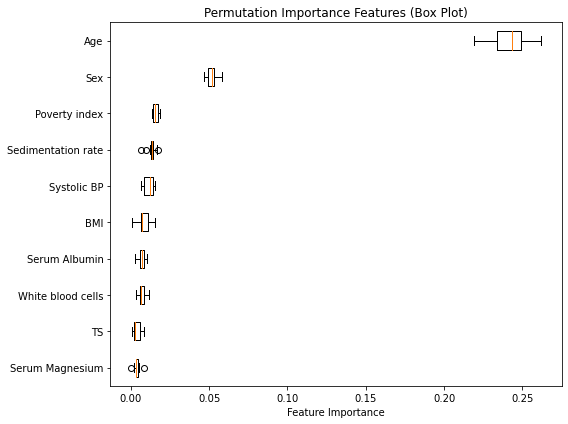

In [51]:
perm = permutation_importance(best_model_overall, X_test, y_test, n_repeats=10, random_state=109)
perm_inds = np.argsort(perm.importances_mean)[-10:]
perm_inds_mean = list(perm_inds.copy())
perm_inds_mean.reverse()
perm_preds = np.array(X_train.columns)[perm_inds_mean]
fig, ax = plt.subplots(figsize = (8,6))
ax.boxplot(perm.importances[perm_inds].T,
            vert=False, labels=np.array(X_train.columns)[perm_inds])
ax.set(title = "Permutation Importance Features (Box Plot)", xlabel = 'Feature Importance')

fig.tight_layout()
plt.show()

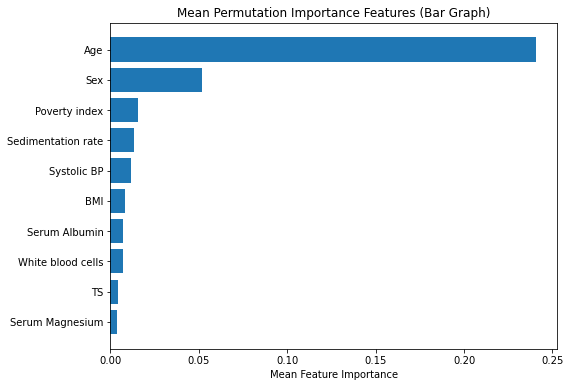

In [52]:
fig, ax = plt.subplots(figsize = (8,6))

ax.barh(list(range(10)), perm.importances_mean[perm_inds_mean], align = 'center')
ax.set_yticks(list(range(10)))
ax.set_yticklabels(perm_preds)
ax.invert_yaxis()
ax.set(title = "Mean Permutation Importance Features (Bar Graph)", xlabel = 'Mean Feature Importance')

plt.show()

#### Feature Selection with SHAP

Finally, we consider SHAP, the merits of which are discussed in the report.

In [53]:
#We perform SHAP explanation on our gradient boosted model
explainerSKGBT = shap.TreeExplainer(best_model_overall)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)

In [54]:
#We take a look at the "local" SHAP plot for the first training entry
j = 0
# initialize js for SHAP
shap.initjs()
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_train[j], X_train.iloc[[j]])

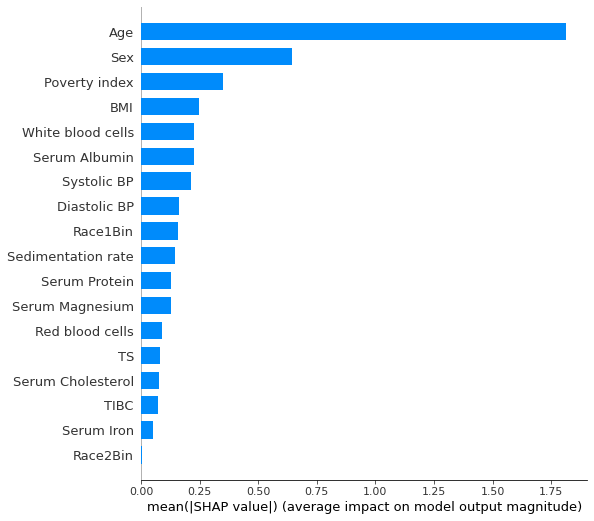

In [55]:
#We inspect the global SHAP values for the model, a measure of overall feature importance using SHAP
shap.summary_plot(shap_values_SKGBT_train, X_train, plot_type="bar")
shap_preds = ['Age', 'Sex', 'Poverty index', 'BMI', 'White blood cells', 'Serum Albumin', 'Systolic BP', 'Diastolic BP', 'Race1Bin', 'Sedimentation rate']

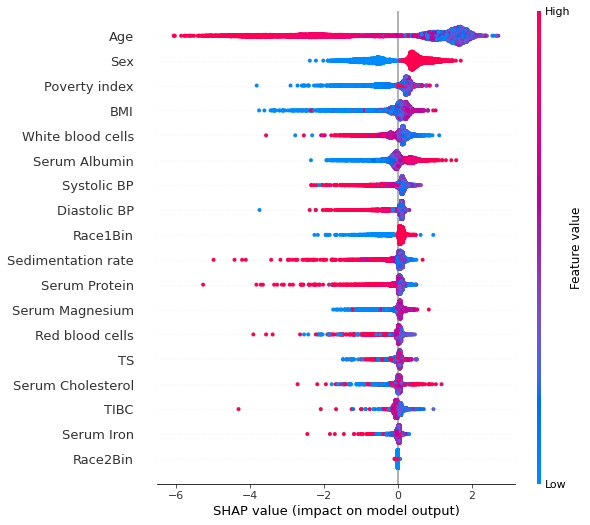

In [56]:
#This plot is similar, but it captures the correlations more accurately
shap.summary_plot(shap_values_SKGBT_train, X_train)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


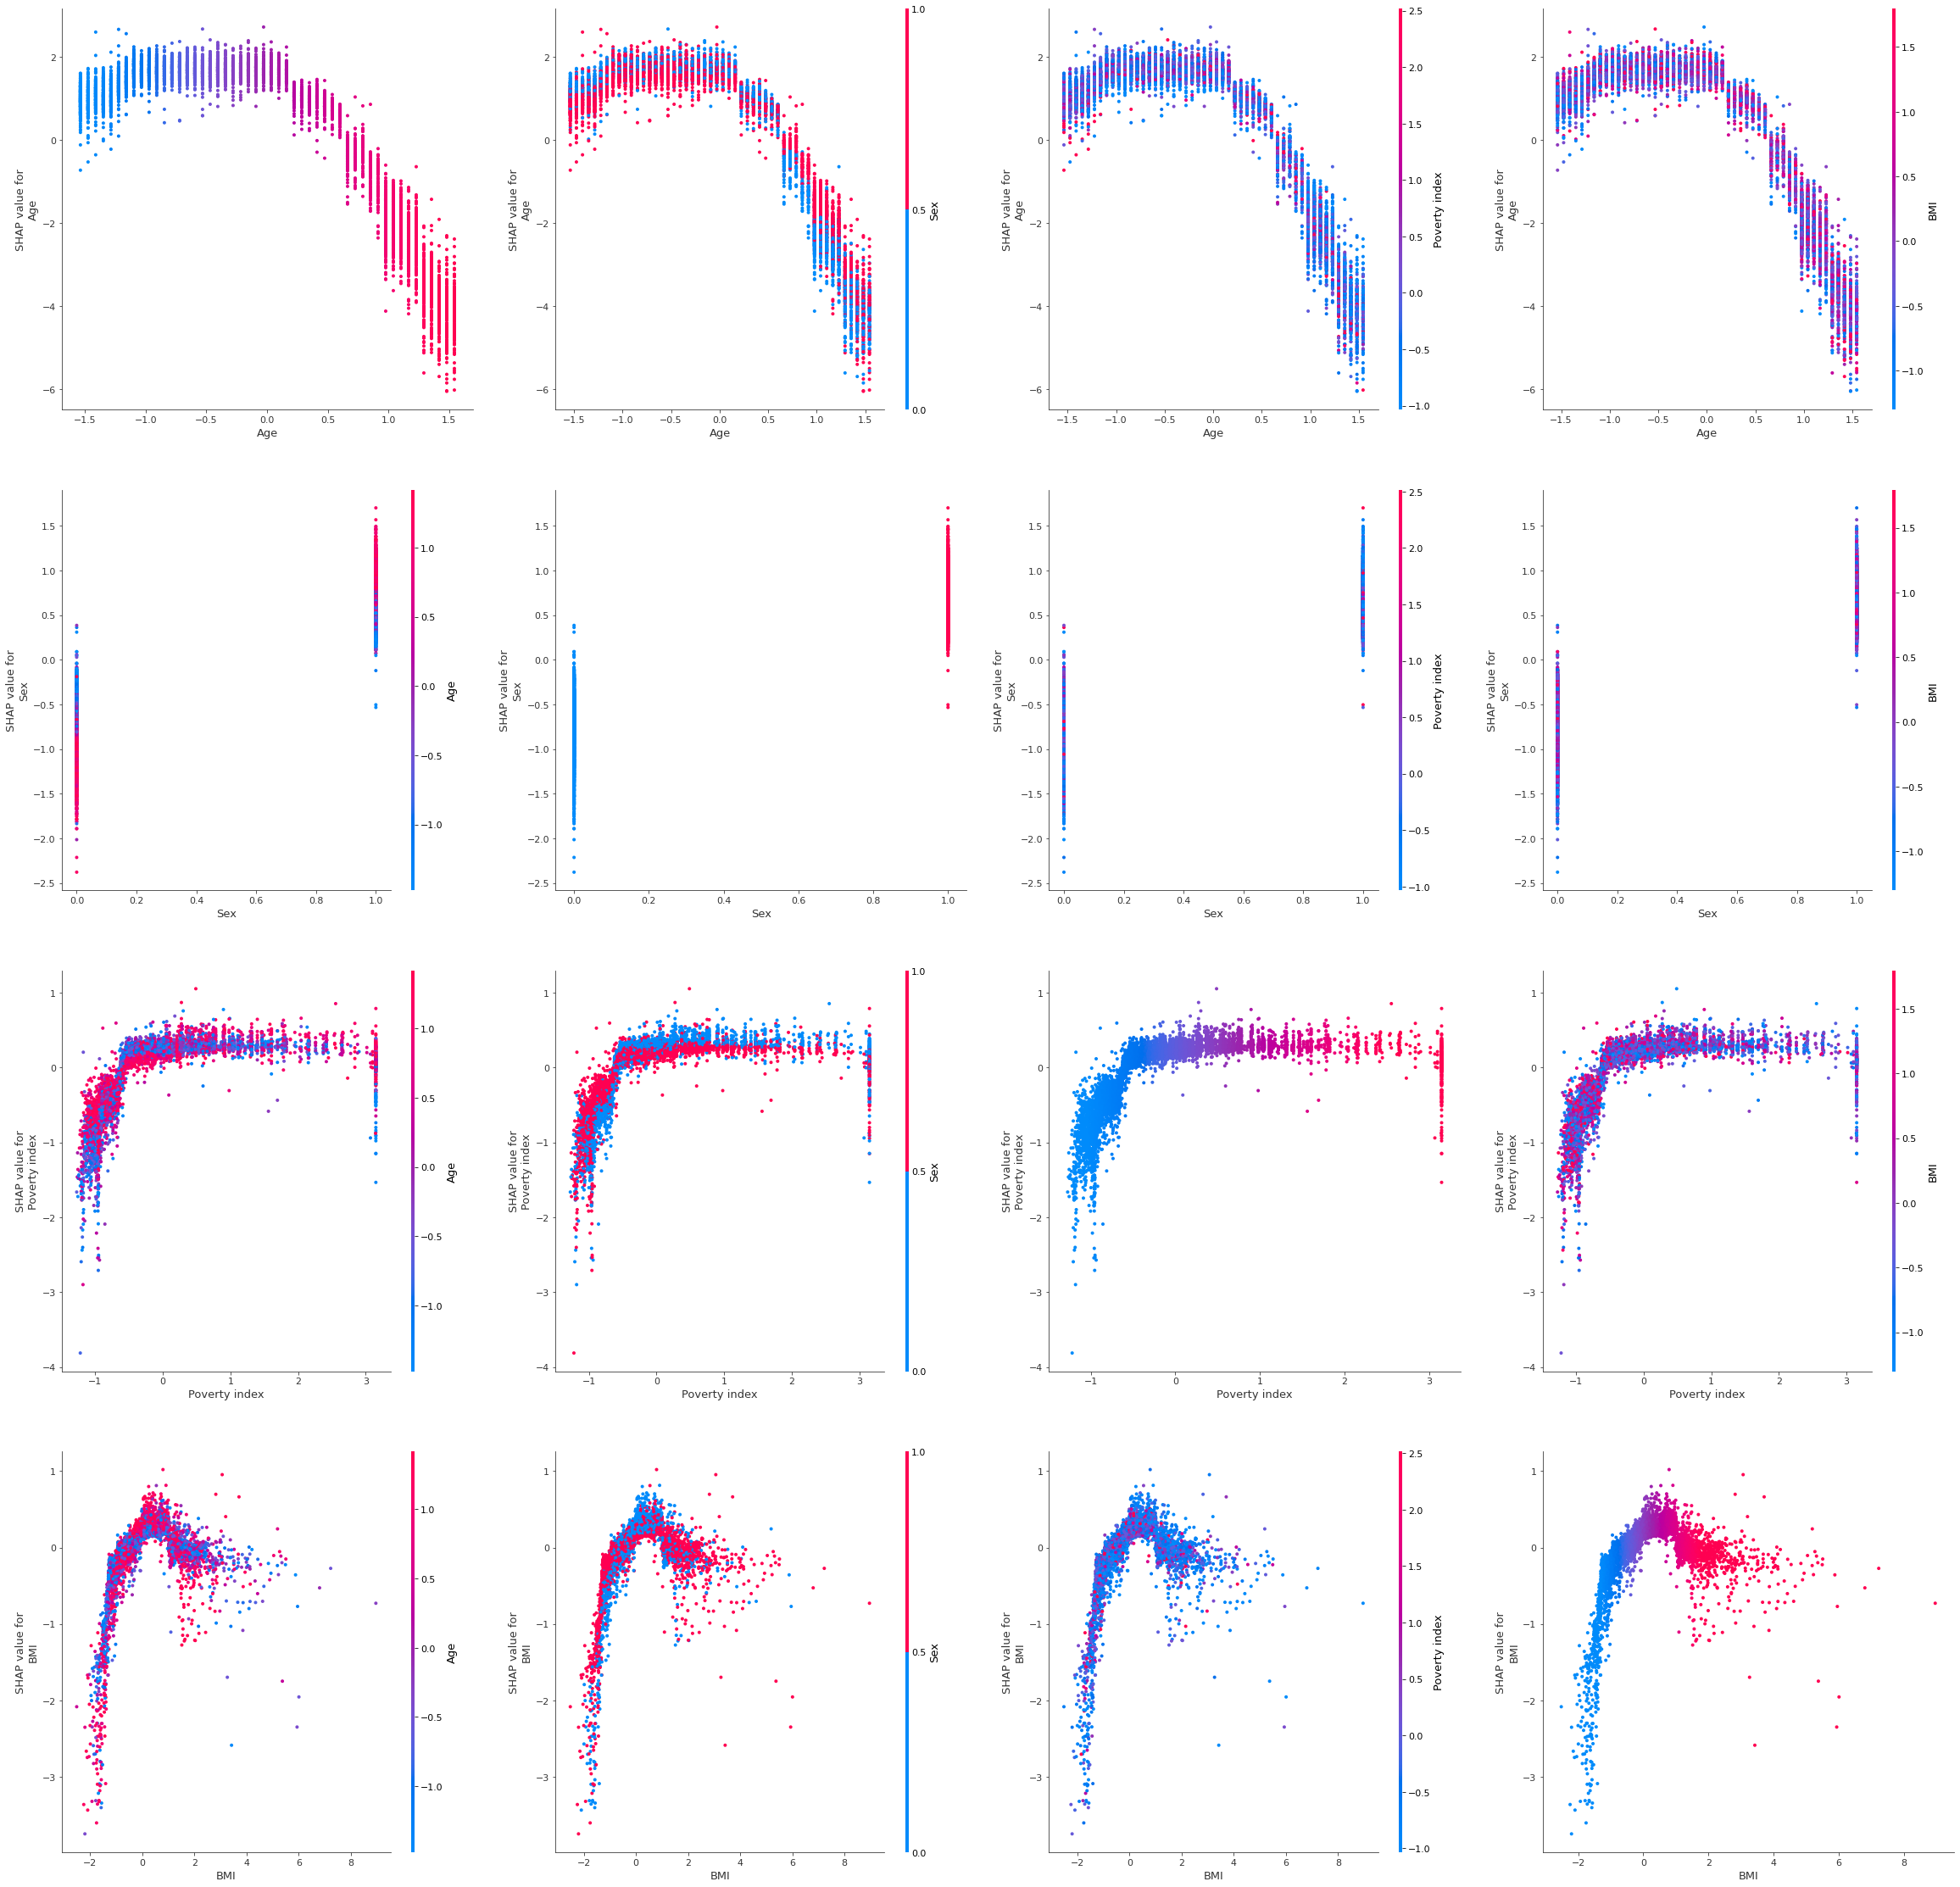

In [57]:
#We can also plot dependence of a pair of features with SHAP values, serving as both an interaction plot and a single
#feature dependence
#We will plot interaction for the top 4 predictors
shap_top_four = shap_preds[:4]
shap_top_four_inds = [list(X_train.columns).index(pred) for pred in shap_top_four]

fig, axs = plt.subplots(4,4, figsize = (40,40))
for pred1 in shap_top_four:
    for ind2 in shap_top_four_inds:
        plot_num = shap_top_four.index(pred1)*len(shap_top_four_inds) + shap_top_four_inds.index(ind2)
        shap.dependence_plot(pred1, shap_values_SKGBT_train, X_train, interaction_index = ind2, ax = axs.ravel()[plot_num], show = False)

# Modeling with Fewer Predictors

We now train gradient boosted regression models on data sets restricted to the top 10 predictors as determined by the different feature importance metrics considered above. We first construct these datasets.

In [58]:
X_train_f, X_test_f = X_train[skb_preds], X_test[skb_preds]
X_train_mdi, X_test_mdi = X_train[mdi_preds], X_test[mdi_preds]
X_train_perm, X_test_perm = X_train[perm_preds], X_test[perm_preds]
X_train_shap, X_test_shap = X_train[shap_preds], X_test[shap_preds]

#### F-Test Model

In [59]:
f_test_mse_tuples, f_best_tuple = hyper_explore('GradientBoostingRegressor', [[.013,.015,.017,.02,.023,.025,.027,.03], [140,145,150,155,160,165,170,175,180]], X_train_f, y_train, X_test_f, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.
30 done.
35 done.
40 done.
45 done.
50 done.
55 done.
60 done.
65 done.
70 done.


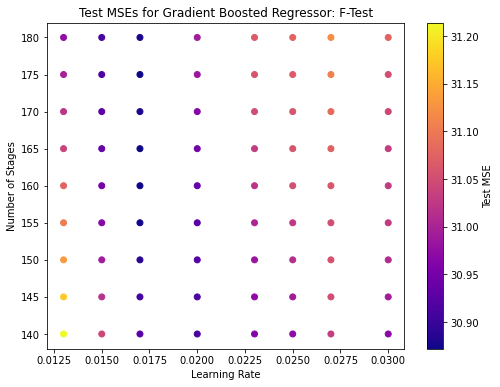

In [60]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in f_test_mse_tuples], [tup[1] for tup in f_test_mse_tuples], [tup[3] for tup in f_test_mse_tuples], 'Gradient Boosted Regressor: F-Test', 'Learning Rate', 'Number of Stages')

In [61]:
print(f'The best random gradient boosted model restricted to F-Test predictors had \nLearning Rate: {f_best_tuple[0]}\nNumber of Stages: {f_best_tuple[1]}\nTraining MSE: {round(f_best_tuple[2],3)}\nTest MSE: {round(f_best_tuple[3],3)}')

The best random gradient boosted model restricted to F-Test predictors had 
Learning Rate: 0.017
Number of Stages: 165
Training MSE: 28.114
Test MSE: 30.872


#### MDI Model

In [62]:
mdi_test_mse_tuples, mdi_best_tuple = hyper_explore('GradientBoostingRegressor', [[.013,.015,.017,.02,.023,.025,.027,.03], [140,145,150,155,160,165,170,175,180]], X_train_mdi, y_train, X_test_mdi, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.
30 done.
35 done.
40 done.
45 done.
50 done.
55 done.
60 done.
65 done.
70 done.


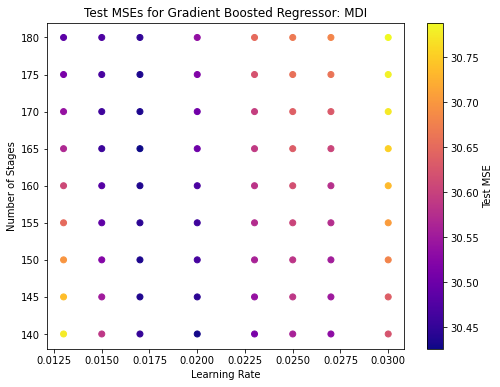

In [63]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in mdi_test_mse_tuples], [tup[1] for tup in mdi_test_mse_tuples], [tup[3] for tup in mdi_test_mse_tuples], 'Gradient Boosted Regressor: MDI', 'Learning Rate', 'Number of Stages')

In [64]:
print(f'The best random gradient boosted model restricted to MDI predictors had \nLearning Rate: {mdi_best_tuple[0]}\nNumber of Stages: {mdi_best_tuple[1]}\nTraining MSE: {round(mdi_best_tuple[2],3)}\nTest MSE: {round(mdi_best_tuple[3],3)}')

The best random gradient boosted model restricted to MDI predictors had 
Learning Rate: 0.017
Number of Stages: 165
Training MSE: 27.295
Test MSE: 30.426


#### Permutation Model

In [65]:
perm_test_mse_tuples, perm_best_tuple = hyper_explore('GradientBoostingRegressor', [[.013,.015,.017,.02,.023,.025,.027,.03], [140,145,150,155,160,165,170,175,180]], X_train_perm, y_train, X_test_perm, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.
30 done.
35 done.
40 done.
45 done.
50 done.
55 done.
60 done.
65 done.
70 done.


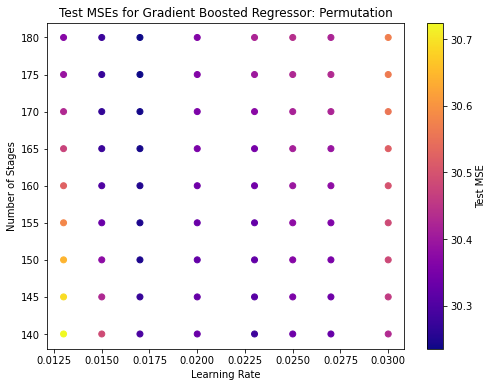

In [66]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in perm_test_mse_tuples], [tup[1] for tup in perm_test_mse_tuples], [tup[3] for tup in perm_test_mse_tuples], 'Gradient Boosted Regressor: Permutation', 'Learning Rate', 'Number of Stages')

In [67]:
print(f'The best random gradient boosted model restricted to Permutation Importance predictors had \nLearning Rate: {perm_best_tuple[0]}\nNumber of Stages: {perm_best_tuple[1]}\nTraining MSE: {round(perm_best_tuple[2],3)}\nTest MSE: {round(perm_best_tuple[3],3)}')


The best random gradient boosted model restricted to Permutation Importance predictors had 
Learning Rate: 0.017
Number of Stages: 175
Training MSE: 27.052
Test MSE: 30.235


#### SHAP Model

In [68]:
shap_test_mse_tuples, shap_best_tuple = hyper_explore('GradientBoostingRegressor', [[.013,.015,.017,.02,.023,.025,.027,.03], [120,125,130,135,140,145,150,155,160,165]], X_train_shap, y_train, X_test_shap, y_test)

5 done.
10 done.
15 done.
20 done.
25 done.
30 done.
35 done.
40 done.
45 done.
50 done.
55 done.
60 done.
65 done.
70 done.
75 done.
80 done.


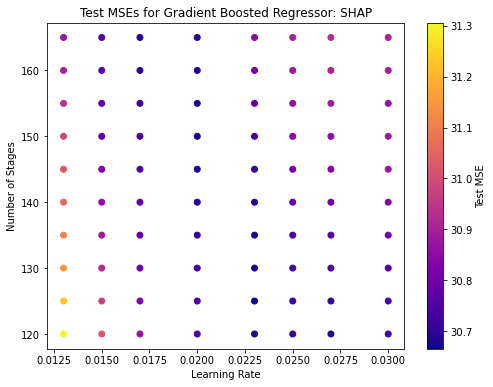

In [69]:
fig, ax = plt.subplots(figsize = (8,6))

plot_cmap(ax, [tup[0] for tup in shap_test_mse_tuples], [tup[1] for tup in shap_test_mse_tuples], [tup[3] for tup in shap_test_mse_tuples], 'Gradient Boosted Regressor: SHAP', 'Learning Rate', 'Number of Stages')

In [70]:
print(f'The best random gradient boosted model restricted to SHAP predictors had \nLearning Rate: {shap_best_tuple[0]}\nNumber of Stages: {shap_best_tuple[1]}\nTraining MSE: {round(shap_best_tuple[2],3)}\nTest MSE: {round(shap_best_tuple[3],3)}')

The best random gradient boosted model restricted to SHAP predictors had 
Learning Rate: 0.023
Number of Stages: 125
Training MSE: 27.237
Test MSE: 30.665


We create a dataframe to easily visualize the results of the various models restricted to smaller predictor subsets.

In [71]:
subset_model_results = pd.DataFrame(columns = ['Feature Importance Method', 'Learning Rate', 'Number of Stages', 'Training MSE', 'Test MSE'], index = range(4))
subset_model_results.loc[0] = ['F-Test', f_best_tuple[0], f_best_tuple[1], f_best_tuple[2], f_best_tuple[3]]
subset_model_results.loc[1] = ['MDI', mdi_best_tuple[0], mdi_best_tuple[1], mdi_best_tuple[2], mdi_best_tuple[3]]
subset_model_results.loc[2] = ['Permutation', perm_best_tuple[0], perm_best_tuple[1], perm_best_tuple[2], perm_best_tuple[3]]
subset_model_results.loc[3] = ['SHAP', shap_best_tuple[0], shap_best_tuple[1], shap_best_tuple[2], shap_best_tuple[3]]

In [72]:
subset_model_results

Feature Importance Method Learning Rate Number of Stages Training MSE  \
0                    F-Test         0.017              165      28.1138   
1                       MDI         0.017              165      27.2948   
2               Permutation         0.017              175      27.0516   
3                      SHAP         0.023              125      27.2367   

  Test MSE  
0  30.8719  
1  30.4259  
2  30.2351  
3  30.6651